## Sentiment Analysis on Movie Reviews

In [1]:
import os 
import re  
import pandas as pd
from sklearn.metrics import confusion_matrix 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
import nltk
nltk.download('stopwords')
from nltk import FreqDist
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
short_pos=pd.read_table("/positive.txt",sep="\n", header=None, encoding='latin-1')
short_neg=pd.read_table("/positive.txt",sep="\n", header=None,encoding='latin-1')

In [3]:
short_pos.head()

,0
0,the rock is destined to be the 21st century's ...
1,"the gorgeously elaborate continuation of "" the..."
2,effective but too-tepid biopic
3,if you sometimes like to go to the movies to h...
4,"emerges as something rare , an issue movie tha..."


In [4]:
short_pos.shape

(5331, 1)

Naming the review column for both positive and negative reviews.

labeling the sentiment column with  for postive reviews and  for negative reviews

In [5]:
short_pos.columns =["Reviews"]
short_neg.columns =["Reviews"]

short_pos["Sentiment"]="1"
short_neg["Sentiment"]="0"

In [6]:
x_short_pos=short_pos[:1000]
x_short_neg=short_neg[:1000]

#### Combining the data to form single dataset with both postive and negative reviews

In [7]:
data=pd.concat([x_short_pos, x_short_neg])
data.index=range(len(data.Sentiment))

In [8]:
data.shape

(2000, 2)

In [9]:
def review_to_words( raw_review ):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review)       # Remove non-letters 
    words = letters_only.lower().split()                      # Convert to lower case, split into individual words                
    stops = set(stopwords.words("english"))                   # convert the stop words to a set    
    meaningful_words = [w for w in words if not w in stops]   # Remove stop words
    return( " ".join( meaningful_words ))                     # Join the words back into one string separated by space, and return the result.

Checking the raw reviews

In [10]:
data["Reviews"][1]

'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth . '

In [11]:
num_reviews = data["Reviews"].size
clean_reviews = []

for i in range( 0, num_reviews ):
    clean_reviews.append( review_to_words( data["Reviews"][i] ) )

In [12]:
clean_reviews[1]

'gorgeously elaborate continuation lord rings trilogy huge column words cannot adequately describe co writer director peter jackson expanded vision j r r tolkien middle earth'

In [13]:
# function to plot top n most frequent words
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top n most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.title("Frequent words plot of Reviews")
  plt.show()

Frequent word for raw reviews


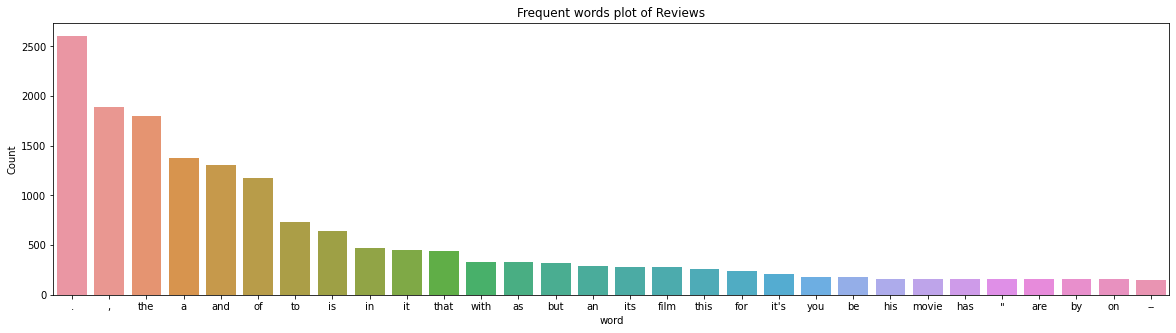

In [14]:
print("Frequent word for raw reviews")
freq_words(data['Reviews'])

Frequent word for cleaned reviews


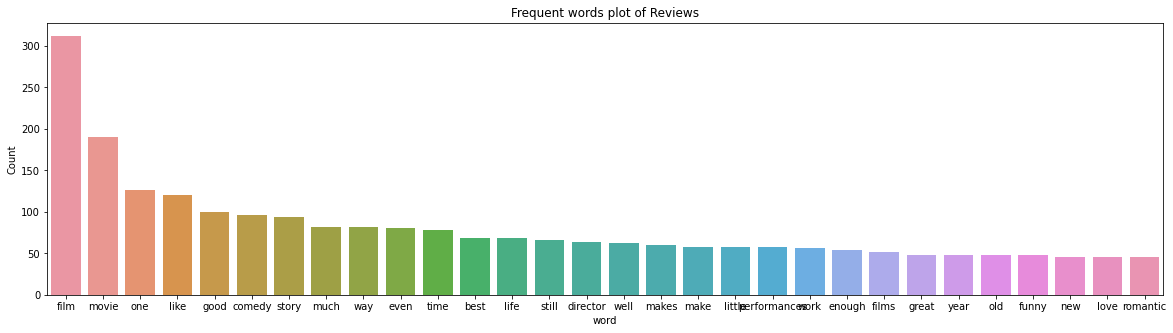

In [15]:
print("Frequent word for cleaned reviews")
freq_words(clean_reviews)

In [16]:
tfidf_vectorizer1 = TfidfVectorizer(ngram_range=(1,3),max_features=800)
data_features = tfidf_vectorizer1.fit_transform(clean_reviews)

data_features = data_features.todense()
data_features=pd.DataFrame(data_features,columns=tfidf_vectorizer1.get_feature_names())

data_features["Sentiment"]=data["Sentiment"]

data_features = data_features.sample(frac =1)

In [17]:
data_features.head(5)

,ability,absorbing,accessible,accomplished,account,achieves,act,acted,acting,action,actor,actors,actress,adaptation,adult,adventure,affecting,affection,age,ages,air,alive,almost,alone,along,also,although,always,amazing,ambiguity,america,american,among,amusing,animated,animation,another,anyone,anything,appeal,...,way,weak,weddings,welcome,well,whether,whole,whose,winning,wit,within,without,woman,women,wonder,wonderful,words,work,working,works,world,worst,worth,worth seeing,worthwhile,worthy,would,writer,writer director,writing,written,ya,year,year old,years,yes,yet,young,zhao,Sentiment
1722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
1749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0
561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.228584,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1
940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1
568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.491853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.527689,0.0,0.0,0.0,1


#### Splitting the to train and test

In [18]:
train,test = train_test_split(data_features, test_size = 0.2) 

cols = [col for col in data_features.columns if col not in ["Sentiment"]]

train.x= train[cols]
train.y=train["Sentiment"]

test.x=test[cols]
test.y=test["Sentiment"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


### Traing a model with Tf-Idf Features

#### Building Logistic regression

In [19]:
lr = LogisticRegression()
lr.fit(train.x, train.y)

preds = lr.predict(train.x)
confusion_matrix(train.y,preds)

accuracy = metrics.accuracy_score(train.y, preds)
print(accuracy)

0.59125


In [20]:
preds = lr.predict(test.x)
confusion_matrix(test.y,preds)
accuracy = metrics.accuracy_score(test.y, preds)
print(accuracy)

0.135


#### Building SVM model

In [21]:
model_linear = svm.SVC(kernel='linear') 
model_linear.fit(train.x,train.y.astype(int)) 

preds = model_linear.predict(train.x)
confusion_matrix(train.y.astype(int),preds)

accuracy = metrics.accuracy_score(train.y.astype(int), preds)
print(accuracy)

0.58875


In [22]:
preds = model_linear.predict(test.x)
confusion_matrix(test.y.astype(int),preds)

accuracy = metrics.accuracy_score(test.y.astype(int), preds)
print(accuracy)

0.145


### Building a bag-of-words features for data

In [23]:
bow = CountVectorizer(binary=False, min_df=5, max_df=1.0, ngram_range=(1,2),max_features=800)
bow_data = bow.fit_transform(clean_reviews)

data_features = bow_data.todense()
data_features=pd.DataFrame(data_features,columns=bow.get_feature_names())

data_features["Sentiment"]=data["Sentiment"]

data_features = data_features.sample(frac =1)

In [24]:
data_features.head(5)

,ability,absorbing,accessible,accomplished,achieves,act,acted,acting,action,actor,actors,actress,adaptation,adult,adventure,affecting,affection,age,ages,air,alive,almost,alone,along,also,although,always,amazing,ambiguity,america,american,among,amusing,animated,animation,another,anyone,anything,appeal,appealing,...,well,whether,whimsy,whole,whose,willing,win,windtalkers,winning,wit,within,without,witty,woman,women,wonder,wonderful,words,work,working,works,world,worst,worth,worth seeing,worthwhile,worthy,would,writer,writer director,writing,written,yarn,year,year old,years,yes,yet,young,Sentiment
1391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1
1760,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1727,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
train,test = train_test_split(data_features, test_size = 0.2) 

cols = [col for col in data_features.columns if col not in ["Sentiment"]]

train.x= train[cols]
train.y=train["Sentiment"]

test.x=test[cols]
test.y=test["Sentiment"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


#### Training the model with bag of words

#### Buiding SVM model

In [26]:
model_linear = svm.SVC(kernel='linear') 
model_linear.fit(train.x,train.y.astype(int)) 
preds = model_linear.predict(train.x)
confusion_matrix(train.y.astype(int),preds)

accuracy = metrics.accuracy_score(train.y.astype(int), preds)
print(accuracy)

0.595


In [27]:
preds = model_linear.predict(test.x)
confusion_matrix(test.y.astype(int),preds)

accuracy = metrics.accuracy_score(test.y.astype(int), preds)
print(accuracy)

0.12


#### Building Logistic Regression

In [28]:
lr = LogisticRegression()
lr.fit(train.x, train.y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
preds = lr.predict(train.x)
confusion_matrix(train.y,preds)

accuracy = metrics.accuracy_score(train.y, preds)
print(accuracy)

0.58875


In [30]:
preds = lr.predict(test.x)
confusion_matrix(test.y,preds)

accuracy = metrics.accuracy_score(test.y, preds)
print(accuracy)

0.145


#### Conclusion :
Movie reviews data set analysis gives insights for a particular movie which is good or 
Bad with respective to reviews. It helps movie makers to decide in which department of movie making it went wrong so that they can access and improve in their next movie for better marketing strategies. Tf-Idf features dataset has given better performance with logistic regression model with accuracy 66.75% .